In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

### 1. Linear Discriminant Analysis using optimization

Consider a case with two classes. We need to maximize:

\begin{equation}
\mathrm{J}(\mathrm{u})=\frac{\mathrm{u}^{\mathrm{T}} \mathrm{S}_{\mathrm{B}} \mathrm{u}}{\mathrm{u}^{\mathrm{T}} \mathrm{S}_{\mathrm{W}} \mathrm{u}}
\end{equation}

where: 

Between class variance is given by:
\begin{equation}
\mathrm{S}_{\mathrm{B}}=\left(\mathrm{m}_{1}-\mathrm{m}_{2}\right)\left(\mathrm{m}_{1}-\mathrm{m}_{2}\right)^{\mathrm{T}}
\end{equation}

Within class variance is given by:
\begin{equation}
s_{1}^{2}+s_{2}^{2}=u^{T} S_{w} u
\end{equation}

\begin{equation}
s_{i}^{2}=\sum_{y \in Wi}\left(y-m_{i}\right)^{2}
\end{equation}

In [2]:
dataset = load_iris()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0


In [3]:
n_features = len(dataset['feature_names'])

# considering only two classes from dataset
df = df[(df['target']==0) | (df['target']==1)].reset_index(drop=True)
data1 = df[df['target']==0][dataset['feature_names']].values
data2 = df[df['target']==1][dataset['feature_names']].values

In [4]:
def func(w, Sb, Sw):
    return (w.T @ Sb @ w) / (w.T @ Sw @ w)

def get_LDA_variables(data1, data2):
    # within class variance
    Sw = np.cov(data1.T) + np.cov(data2.T)

    # between class variance
    m1 = np.mean(data1, axis=0).reshape(-1, 1)
    m2 = np.mean(data2, axis=0).reshape(-1, 1)
    Sb = (m1 - m2) @ (m1 - m2).T

    assert Sb.shape == (n_features, n_features)
    assert Sw.shape == (n_features, n_features)
    return Sb, Sw, m1, m2    

def get_LDA(data1, data2):
    Sb, Sw, m1, m2 = get_LDA_variables(data1, data2)
    
    optim_func = lambda w: - func(w, Sb, Sw)
    consts = ({'type':'eq', 'fun': lambda w: w.T @ w - 1})

    w0 = np.random.random(size=(n_features,))
    sol = minimize(optim_func, w0, constraints=consts)
    return sol    

In [5]:
sol = get_LDA(data1, data2)
sol

     fun: -51.616770917169795
     jac: array([ 0.00293779, -0.00164366,  0.00150061, -0.00172901])
 message: 'Optimization terminated successfully'
    nfev: 89
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-0.07278246, -0.42969466,  0.51893816,  0.73536957])

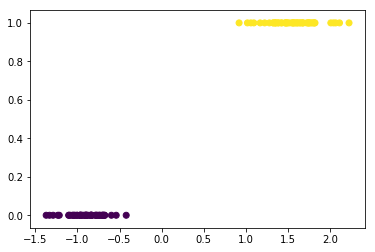

In [6]:
X = np.append(data1 @ sol.x, data2 @ sol.x)
y = np.array([0] * len(data1) + [1] * len(data2))

df1 = pd.DataFrame(np.vstack((X, y)).transpose(), columns=['X', 'y'])
df1 = df1.sample(frac = 1).reset_index(drop=True)
plt.scatter(df1['X'], df1['y'], c=df1['y'])
plt.show()

In [7]:
# getting linear component using Sklearn library
clf = LinearDiscriminantAnalysis()
X = df[dataset['feature_names']]
y = df['target']

clf.fit(X, y)
result = np.squeeze(clf.coef_ / np.linalg.norm(clf.coef_))
sol.x, result

(array([-0.07278246, -0.42969466,  0.51893816,  0.73536957]),
 array([-0.07278252, -0.4296938 ,  0.51893802,  0.73537016]))

Linear Component from optimization and through Sklearn library is similar.

#### Direct solution to the optimization problem:

Solving the above optimization results into an eigenvalue problem whose solution is given by:

\begin{equation}
\mathrm{u}=\mathrm{S}_{\mathrm{W}}^{-1}\left(\mathrm{~m}_{1}-\mathrm{m}_{2}\right)
\end{equation}

In [8]:
Sb, Sw, m1, m2 = get_LDA_variables(data1, data2)

z = np.linalg.inv(Sw) @ (m1 - m2)
z = z / np.linalg.norm(z)
z = np.squeeze(z)
z

array([ 0.07278252,  0.4296938 , -0.51893802, -0.73537016])

### 2. Comparing LDA with Principal Component Analysis (PCA)

PCA aims to maximize variance in data while LDA aims to maximize separability between classes. Let's compare PCA components with LDA components. 

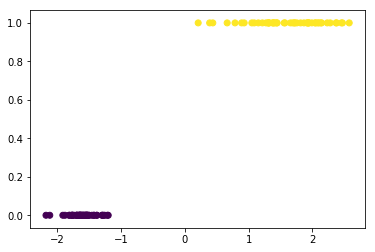

In [9]:
# PCA
data = np.vstack((data1, data2))
y = np.array([0] * len(data1) + [1] * len(data2))
pca = PCA(n_components=1)
X = pca.fit_transform(data).ravel()

df1 = pd.DataFrame(np.vstack((X, y)).transpose(), columns=['X', 'y'])
df1 = df1.sample(frac = 1).reset_index(drop=True)
plt.scatter(df1['X'], df1['y'], c=df1['y'])
plt.show()

In [10]:
def get_cosine_sim(v1, v2):
    return v1 @ v2 / (np.linalg.norm(v1) * np.linalg.norm(v2))

v1 = sol.x
v2 = pca.components_.ravel()
get_cosine_sim(v1, v2) * 180 / np.pi

42.73299751120726

We can notice that there is some difference in directions between PCA and LDA components. However, in terms of results from above figures, there doesn't seem to be much noticeable difference. 

### Additional Notes:

1. Discriminant Analysis for more than 2 classes is called Multiple Discriminant Analysis (MDA).
2. Discriminant Analysis reduces dimension from K to K-1, unlike PCA which can reduce dimensions >= 1.
3. Linear Discriminant Analysis fails when the mean vector of two classes is same (for example, two classes in concentric circles/hyperspheres):
    1. In that case, the optimizing function is equal to zero. 
    2. However, PCA (Linear PCA/Non-Linear PCA) can work well.
4. There can be cases where both LDA and PCA fail (for example - Diagonal points of square belonging to two different classes):
    1. Here, mean vector is same, so LDA fails.
    2. Here, maximum variance is equal along both diagonals, so PCA fails.
    3. Typically happens when there is large overlap between classes.